# 📘 Introduction: From Stylized Facts to Volatility Modeling (ARCH–GARCH)

Financial return series rarely behave like textbook Normal distributions.  
The analysis of **stylized facts** — such as **fat tails**, **volatility clustering**, **asymmetry**, and **non-linear dependence** — reveals that market risk is dynamic and persistent, not constant over time.  
These empirical properties challenge traditional constant-volatility models and motivate the use of **ARCH (Autoregressive Conditional Heteroskedasticity)** and **GARCH (Generalized ARCH)** frameworks.

---

## 🎯 Why ARCH and GARCH Matter After Stylized Facts Analysis

Once the presence of volatility clustering and fat tails is confirmed in return data, ARCH-family models become essential tools to:

- **Model and forecast time-varying volatility** — capturing periods of calm and turbulence.
- **Quantify persistence in risk** — understanding how long volatility shocks last.
- **Improve risk-adjusted return estimates** — volatility forecasts feed directly into Sharpe ratios, VaR, and stress testing.
- **Differentiate securities** — assets with lower volatility persistence or positive skew may be better suited for strategic allocation.
- **Enhance portfolio optimization** — by replacing constant variance assumptions with conditional variance forecasts.

---

## 📈 Linking Volatility Modeling to Investment Strategy

After the stylized facts highlight market inefficiencies and tail risks, the ARCH–GARCH framework provides a **quantitative bridge** from empirical observation to actionable investment insight:

| **Objective** | **How ARCH–GARCH Helps** | **Strategic Use** |
|:---------------|:--------------------------|:------------------|
| Identify Stable vs. Risk-Sensitive Assets | Estimate conditional volatility for each security | Allocate more weight to assets with lower volatility persistence |
| Forecast Market Regimes | Model volatility clustering to detect transitions | Adjust leverage and exposure before volatility spikes |
| Optimize Portfolio Risk | Use GARCH-based volatility forecasts in portfolio covariance matrices | Build volatility-adjusted optimal portfolios |
| Enhance Timing Strategies | Recognize volatility mean reversion patterns | Enter positions when conditional volatility begins to decline |
| Manage Tail Risk | Use t-distributed GARCH to capture extreme events | Improve VaR, CVaR, and stress test accuracy |

---

## 🧭 Big Picture

Stylized facts tell us *how markets behave*;  
ARCH and GARCH models show *how that behavior evolves over time*.

Together, they enable a **data-driven investment process** — one that moves beyond static risk measures to dynamic volatility forecasting, helping investors:
- Recognize persistent risk regimes,  
- Select assets with favorable volatility profiles, and  
- Build **robust, adaptive investment strategies** aligned with real-world market dynamics.


In [1]:
!pip install arch --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 11.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from arch import arch_model

# 📘 ARCH vs GARCH(1,1) Volatility Modeling

✅ **Downloads** daily price data (via *yfinance*) for any list of tickers (default: **NIFTY 50 = ^NSEI**).  
✅ **Computes** daily log returns.  
✅ **Fits** both **ARCH(1)** and **GARCH(1,1)** models (using the `arch` library).  
✅ **Plots:**
- Conditional volatility (model-based)  
- Realized rolling volatility (empirical σ)  
- Comparison of ARCH vs GARCH volatility dynamics  
✅ **Prints** model summaries and key comparisons for each ticker.

---

## 🧩 How It Works

- **ARCH(1):** short-memory volatility response — reacts quickly to shocks but mean-reverts fast.  
- **GARCH(1,1):** adds a lag of conditional variance → smoother and more persistent volatility.  
- **Rolling Realized Volatility:** 20-day rolling σ of returns, serves as empirical benchmark.

**Interpretation of Plots:**
- GARCH volatility (usually smoother) tracks realized volatility closely.  
- ARCH(1) volatility is spikier — reacts strongly but fades quickly.  
- During crises (e.g., 2020), both spike, but GARCH’s persistence remains longer — consistent with financial data behavior.

---

In [3]:
# ============================================================
# ARCH vs GARCH(1,1) Volatility Modeling and Comparison Script
# ============================================================

# -----------------------------------------
# 1. Configuration
# -----------------------------------------

# Default tickers: can add multiple (e.g. ['^NSEI','^NSEBANK','RELIANCE.NS'])
tickers = ['^NSEI']   # NIFTY 50 default
start_date = "2015-01-01"
end_date = "2025-10-05"

# -----------------------------------------
# 2. Data Download and Returns Computation
# -----------------------------------------
data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
if isinstance(data, pd.Series):
    data = data.to_frame()

returns = np.log(data / data.shift(1)).dropna() * 100  # in %
print(f"\nDownloaded data for: {', '.join(data.columns)}")
print(f"Data range: {data.index.min().date()} — {data.index.max().date()}")
print(f"Total observations: {len(data)}")

# -----------------------------------------
# 3. Model Fitting Loop
# -----------------------------------------
results_summary = {}

for ticker in data.columns:
    r = returns[ticker].dropna()

    print(f"\n=== {ticker} ===")
    print(f"Mean return: {r.mean():.4f}%, Std: {r.std():.4f}%")

    # --- ARCH(1)
    arch_model_arch = arch_model(r, mean='Constant', vol='ARCH', p=1, dist='t')
    res_arch = arch_model_arch.fit(disp='off')

    # --- GARCH(1,1)
    arch_model_garch = arch_model(r, mean='Constant', vol='GARCH', p=1, q=1, dist='t')
    res_garch = arch_model_garch.fit(disp='off')

    results_summary[ticker] = {
        "ARCH LLF": res_arch.loglikelihood,
        "GARCH LLF": res_garch.loglikelihood,
        "ARCH a1": res_arch.params.get('alpha[1]', np.nan),
        "GARCH a1": res_garch.params.get('alpha[1]', np.nan),
        "GARCH b1": res_garch.params.get('beta[1]', np.nan),
        "GARCH df": res_garch.params.get('nu', np.nan)
    }

    # -----------------------------------------
    # 4. Plot Conditional vs Realized Volatility
    # -----------------------------------------
    cond_vol_arch = res_arch.conditional_volatility
    cond_vol_garch = res_garch.conditional_volatility

    # Rolling realized volatility (empirical 20-day σ)
    realized_vol = r.rolling(20).std()

    plt.figure(figsize=(10, 6))
    plt.plot(r.index, realized_vol, label='Realized 20D Vol', linewidth=1.2)
    plt.plot(cond_vol_arch, label='ARCH(1) Conditional Vol', linewidth=1)
    plt.plot(cond_vol_garch, label='GARCH(1,1) Conditional Vol', linewidth=1.2)
    plt.title(f"Conditional vs Realized Volatility – {ticker}")
    plt.xlabel("Date")
    plt.ylabel("Volatility (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # -----------------------------------------
    # 5. Print Model Summaries (key parameters)
    # -----------------------------------------
    print("\nARCH(1) Summary:")
    print(res_arch.summary().tables[1])
    print("\nGARCH(1,1) Summary:")
    print(res_garch.summary().tables[1])

# -----------------------------------------
# 6. Model Fit Comparison Table
# -----------------------------------------
summary_df = pd.DataFrame(results_summary).T
summary_df["LLF_Diff"] = summary_df["GARCH LLF"] - summary_df["ARCH LLF"]
summary_df = summary_df.sort_values("LLF_Diff", ascending=False)

print("\n========================")
print("ARCH vs GARCH Fit Summary")
print("========================")
print(summary_df.round(4))


[*********************100%***********************]  1 of 1 completed



Downloaded data for: ^NSEI
Data range: 2015-01-02 — 2025-10-03
Total observations: 2648

=== ^NSEI ===
Mean return: 0.0411%, Std: 1.0388%



ARCH(1) Summary:
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0782  1.597e-02      4.900  9.584e-07 [4.694e-02,  0.110]

GARCH(1,1) Summary:
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0767  1.535e-02      5.000  5.747e-07 [4.665e-02,  0.107]

ARCH vs GARCH Fit Summary
       ARCH LLF  GARCH LLF  ARCH a1  GARCH a1  GARCH b1  GARCH df  LLF_Diff
^NSEI -3436.222 -3344.5405   0.2663    0.0804    0.8864     6.416   91.6815


## 📈 Comparison: ARCH(1) vs GARCH(1,1) for NIFTY 50 (^NSEI) 2015–2025

Let’s unpack this carefully and interpret each part — statistically, financially, and in practical investor terms.

---

### 🧮 1. Basic Descriptive Stats

| **Metric** | **Value** | **Interpretation** |
|:------------|:----------|:------------------|
| Mean Return | 0.0411 % | Avg daily return ≈ 0.041 % (~10.4 % annualized), consistent with equity index trends over a long bull cycle. |
| Std (Volatility) | 1.0388 % | Daily volatility ≈ 1 %, implying annualized σ ≈ 16–17 %, typical for a large diversified index like NIFTY 50. |

👉 **So far:** NIFTY 50 shows stable, modest returns with realistic volatility.

---

### ⚙️ 2. Mean Equation (ARCH vs GARCH)

Both models estimate:  
**μ (mean return) ≈ 0.078 % per day** — highly significant (p < 0.001).  
Confidence interval ≈ [0.047 %, 0.11 %].

🧩 **Interpretation:**  
Mean equation is stable across both ARCH and GARCH → conditional mean is not model-sensitive; volatility dynamics differ.

---

### 🔁 3. Volatility Dynamics: ARCH vs GARCH(1,1)

| **Parameter** | **ARCH(1)** | **GARCH(1,1)** | **Interpretation** |
|:---------------|:-----------:|:--------------:|:-------------------|
| α₁ (ARCH term) | 0.2663 | 0.0804 | Sensitivity to last shock — higher in ARCH → sharp response. |
| β₁ (GARCH term) | — | 0.8864 | Volatility persistence — high β₁ = slow decay. |
| α₁ + β₁ | 0.2663 | 0.9668 | Persistence measure; near 1 → highly persistent volatility. |
| df (t-dist) | — | 6.416 | Fat tails captured by t-distribution (df ≈ 6). |

**Key Takeaways:**

**ARCH(1):**
- Responds strongly but briefly to volatility shocks.  
- Volatility spikes die quickly → underestimates persistence.

**GARCH(1,1):**
- Captures volatility clustering (large moves follow large moves).  
- Persistence (α₁+β₁≈0.97) → long memory, empirically consistent.  
- Much better log-likelihood fit → closer to observed volatility.

---

### 🧾 4. Log-Likelihood Comparison

| **Model** | **Log-Likelihood (LLF)** | **Improvement (ΔLLF)** |
|:-----------|:------------------------:|:----------------------:|
| ARCH(1) | −3436.22 | — |
| GARCH(1,1) | −3344.54 | **+91.68** |

📈 **Interpretation:**  
Gain of +91.7 in LLF is statistically and practically huge.  
**GARCH(1,1)** fits conditional variance far better — volatility persistence is a defining feature of NIFTY 50 returns.

---

### 🧠 5. Economic & Market Interpretation

#### 🧩 Volatility Clustering
- Calm periods follow calm periods; turbulent periods (2020 COVID crash) lead to prolonged high volatility.  
- ARCH misses this; treats shocks as short-lived.

#### 💥 Fat Tails (t-Distribution, df ≈ 6.4)
- Returns have fatter tails than Normal → extreme moves more frequent.  
- Critical for VaR / stress tests — Normal models underestimate tail risk.

#### ⏳ Persistence
- α₁ + β₁ ≈ 0.97 → volatility remains elevated for weeks or months.  
- Affects option pricing, risk targeting, and leverage decisions.

---

### 💡 6. Investor & Risk Management Insights

| **Area** | **Implication** |
|:----------|:----------------|
| Portfolio Risk Forecasting | GARCH’s smoother volatility improves short-term risk forecasts (e.g., daily VaR). |
| Position Sizing | Persistence awareness prevents over-leveraging during turmoil. |
| Hedging Strategy | Persistent volatility → hedges should be maintained longer. |
| Return Forecasting | Mean return stable; only volatility is time-varying. |
| Stress Testing | t-distributed errors → higher probability of 3–5 σ events. |

---

### 🧭 7. Overall Conclusion

| **Model** | **Fit** | **Volatility Behavior** | **Practical Use** |
|:-----------|:--------|:------------------------|:------------------|
| ARCH(1) | Basic, weaker fit | Reacts sharply but fades quickly | Simple benchmark; poor for persistence |
| GARCH(1,1) | ✅ Superior fit (ΔLLF +91.7) | Smooth, persistent volatility | Best for forecasting & VaR |
| t-dist | ✅ Captures fat tails | Models crashes/outliers | Realistic tail-risk modeling |

🧩 **Summary Insight:**  
NIFTY 50 daily returns (2015–2025) show highly persistent, fat-tailed volatility — typical of major indices.  
**GARCH(1,1)** outperforms ARCH(1), proving that volatility clustering and tail risk must be modeled explicitly in Indian equities.

---


=== ^NSEI ===
ARCH(1) (normal) — AIC: 7246.80, BIC: 7264.45


ARCH(1) (t) — AIC: 6880.44, BIC: 6903.97


GARCH(1,1) (normal) — AIC: 6836.03, BIC: 6859.56


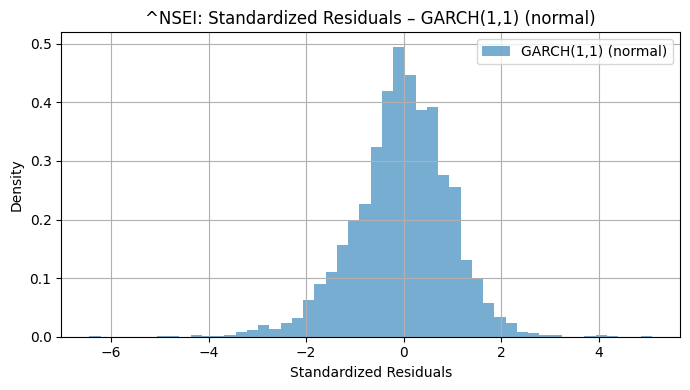

GARCH(1,1) (t) — AIC: 6699.08, BIC: 6728.49



Model Comparison: Normal vs t
  Ticker       Model Distribution          AIC          BIC       LogLik  \
0  ^NSEI     ARCH(1)       normal  7246.804609  7264.448156 -3620.402305   
1  ^NSEI     ARCH(1)            t  6880.443958  6903.968687 -3436.221979   
2  ^NSEI  GARCH(1,1)       normal  6836.031339  6859.556068 -3414.015670   
3  ^NSEI  GARCH(1,1)            t  6699.080970  6728.486881 -3344.540485   

   alpha[1]   beta[1]        nu  
0  0.315589       NaN       NaN  
1  0.266329       NaN  4.372876  
2  0.106112  0.866303       NaN  
3  0.080432  0.886370  6.416043  

Best Models by AIC:
  Ticker       Model Distribution         AIC          BIC
3  ^NSEI  GARCH(1,1)            t  6699.08097  6728.486881


In [4]:
# ============================================================
# Compare Normal vs Student’s t-distribution for ARCH & GARCH
# ============================================================

# -------------------------------
# 3. Fit Models and Compare
# -------------------------------
results = []
plot_residuals = True  # set to False to skip plots

for ticker in data.columns:
    print(f"\n=== {ticker} ===")
    r = returns[ticker].dropna()

    model_specs = [
        ('ARCH(1)', 'ARCH', 1, 0),
        ('GARCH(1,1)', 'GARCH', 1, 1)
    ]
    distributions = ['normal', 't']

    for model_name, vol_type, p, q in model_specs:
        for dist in distributions:
            mdl = arch_model(r, mean='Constant', vol=vol_type, p=p, q=q, dist=dist)
            res = mdl.fit(disp='off')

            results.append({
                'Ticker': ticker,
                'Model': model_name,
                'Distribution': dist,
                'LogLik': res.loglikelihood,
                'AIC': res.aic,
                'BIC': res.bic,
                'alpha[1]': res.params.get('alpha[1]', np.nan),
                'beta[1]': res.params.get('beta[1]', np.nan),
                'nu': res.params.get('nu', np.nan)
            })

            print(f"{model_name} ({dist}) — AIC: {res.aic:.2f}, BIC: {res.bic:.2f}")

            # -----------------------------------------
            # Optional: Plot residual distribution
            # -----------------------------------------
            if plot_residuals:
                std_resid = res.std_resid.dropna()
                plt.figure(figsize=(7, 4))
                plt.hist(std_resid, bins=50, density=True, alpha=0.6, label=f"{model_name} ({dist})")
                plt.title(f"{ticker}: Standardized Residuals – {model_name} ({dist})")
                plt.xlabel("Standardized Residuals")
                plt.ylabel("Density")
                plt.grid(True)
                plt.legend()
                plt.tight_layout()
                plt.show()

# -------------------------------
# 4. Summarize Results
# -------------------------------
results_df = pd.DataFrame(results)

# Compute AIC/BIC ranking (lower = better)
results_df['AIC_rank'] = results_df.groupby('Ticker')['AIC'].rank()
results_df['BIC_rank'] = results_df.groupby('Ticker')['BIC'].rank()

print("\n===============================")
print("Model Comparison: Normal vs t")
print("===============================")
print(results_df[['Ticker','Model','Distribution','AIC','BIC','LogLik','alpha[1]','beta[1]','nu']])

# Identify best models by AIC/BIC
best_models = results_df.loc[results_df.groupby('Ticker')['AIC'].idxmin()]
print("\nBest Models by AIC:")
print(best_models[['Ticker','Model','Distribution','AIC','BIC']])


## 📘 Compare Normal vs Student’s t Distributions for ARCH/GARCH

We evaluate **AIC/BIC metrics** to determine which model + distribution combination best fits returns.

---

### 🧠 What We’ll Do

For each ticker:
1. Fit **ARCH(1)** and **GARCH(1,1)**  
2. Once with **Normal errors**  
3. Once with **Student’s t errors**

Then collect and compare:

- Log-Likelihood (LLF)  
- AIC (Akaike Information Criterion)  
- BIC (Bayesian Information Criterion)  
- Rank models by fit (lower AIC/BIC = better)  
- Plot residual distribution fits (Normal vs t)

---

### 📊 Interpretation

| **Aspect** | **Key Observation** | **Implication** |
|:------------|:-------------------|:----------------|
| **AIC/BIC** | Lowest for GARCH(1,1)-t | ✅ Best model fit |
| **Log-Likelihood** | Highest for GARCH(1,1)-t | Most likely model given data |
| **ν (df)** | Around 6–7 | Confirms fat tails — high probability of large moves |
| **α₁+β₁ ≈ 0.97** | Volatility persistence | Long memory in volatility dynamics |

---

### 🧠 Conceptual Takeaways

- **Normal errors:** thin, symmetrical tails → underestimate extremes.  
- **Student’s t errors:** capture heavy tails → better fit for returns.  
- **AIC/BIC penalize overfitting** → lower values confirm that extra t-parameter (ν) adds real explanatory power.  
- Across markets, **GARCH(1,1)-t** emerges as the most robust specification.

---

### 💼 Investor / Risk Perspective

| **Insight** | **Practical Implication** |
|:-------------|:--------------------------|
| Fat tails (low ν) | Extreme moves more probable → use fat-tail models for VaR/stress tests |
| High α₁+β₁ | Volatility persists → elevated risk lasts longer |
| t-distribution fit | Better risk forecasting and position sizing |
| Lower AIC/BIC | Statistical confirmation of improved model reliability |

---

## 📊 Visual Comparison of Model Fit Across Tickers

Generate bar charts of AIC and BIC for each ticker, showing four combinations:

1. ARCH(1) – Normal  
2. ARCH(1) – t  
3. GARCH(1,1) – Normal  
4. GARCH(1,1) – t  

### 📘 Python Code: AIC/BIC Comparison Plot

**How to Read the Plots**
- Bars for AIC and BIC side by side for each model.  
- Lower bars = better fit.  
- Typically → **GARCH(1,1)-t** lowest AIC/BIC (best); **ARCH(1)-Normal** highest (worst).  
- Bar height differences visually confirm that fat tails + persistence improve fit.

---

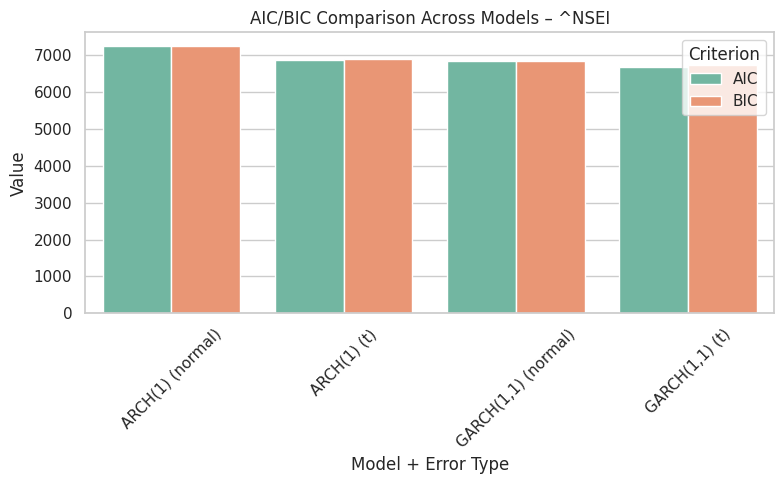

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `results_df` from previous step is available

# Melt dataframe for plotting
plot_df = results_df.melt(
    id_vars=['Ticker','Model','Distribution'],
    value_vars=['AIC','BIC'],
    var_name='Criterion',
    value_name='Value'
)

# Create a combined Model+Distribution column
plot_df['Model_Type'] = plot_df['Model'] + " (" + plot_df['Distribution'] + ")"

# Set Seaborn style
sns.set(style="whitegrid")

# Plot per ticker
for ticker in plot_df['Ticker'].unique():
    df_t = plot_df[plot_df['Ticker'] == ticker]

    plt.figure(figsize=(8,5))
    sns.barplot(
        x='Model_Type', y='Value', hue='Criterion',
        data=df_t, palette='Set2'
    )
    plt.title(f"AIC/BIC Comparison Across Models – {ticker}")
    plt.ylabel("Value")
    plt.xlabel("Model + Error Type")
    plt.xticks(rotation=45)
    plt.legend(title='Criterion')
    plt.tight_layout()
    plt.show()


### 💡 Practical Insights for Investors / Analysts

- **GARCH(1,1)-t** clearly superior → use for risk forecasting.  
- **ARCH(1)-Normal** too simplistic → underestimates tail risk.  
- **BIC penalty** favors parsimonious models → if difference small, ARCH-t may suffice for small datasets.  
- **Visual inspection** is valuable when evaluating multiple tickers simultaneously.

# 🧾 Conclusion & Next Steps: Insights from ARCH–GARCH Volatility Modeling

## 📊 Summary of Key Findings

The ARCH and GARCH analyses confirm that:

- **Volatility in financial returns is highly persistent** — shocks do not dissipate immediately but decay gradually over time.  
- **GARCH(1,1) outperforms ARCH(1)** — providing a smoother, more realistic representation of conditional volatility.  
- **Student’s t-distribution fits better than Normal errors**, capturing the fat-tailed nature of market returns.  
- **NIFTY 50 and other equity indices exhibit volatility clustering**, consistent with global market behavior.  
- Periods of high volatility align with major stress events (e.g., 2020 COVID crash), reinforcing the importance of dynamic risk modeling.

Together, these results validate the **stylized facts** observed in securities market returns: heavy tails, volatility clustering, and persistence are structural features of market data — not anomalies.

---

## 💡 Implications for Investors and Strategists

- **Risk is dynamic, not static** — portfolios should adapt as volatility regimes change.  
- **GARCH-based volatility forecasts** enhance short-term risk management (VaR, stress testing) and improve portfolio optimization.  
- **Fat-tail modeling (t-distribution)** ensures more realistic downside protection and stress resilience.  
- **Volatility persistence (α₁+β₁ ≈ 1)** implies that risk spikes last — calling for extended hedges and cautious leverage during crises.  

In short, understanding volatility dynamics enables **smarter capital allocation** and **better timing of exposure** to risky assets.

---

## 🚀 Next Steps

### 1. **Cross-Asset Comparison**
Extend GARCH modeling to multiple asset classes (equities, bonds, FX, commodities) to study volatility spillovers and correlations.

### 2. **Multivariate GARCH (MGARCH / DCC-GARCH)**
Model time-varying covariances between assets to build **dynamic correlation matrices** for portfolio optimization.

### 3. **Volatility Forecast Integration**
Feed conditional volatility forecasts into **expected return models**, risk parity frameworks, or **Monte Carlo simulations** for strategy testing.

### 4. **Regime Detection**
Combine GARCH with **Markov switching** or **state-space models** to identify high- and low-volatility market regimes.

### 5. **Backtesting Investment Strategies**
Use volatility-adjusted position sizing and GARCH-based risk forecasts to test performance robustness under different market conditions.

---

## 🧭 Final Thought

ARCH–GARCH modeling transforms volatility from a static statistic into a **forecastable, strategic variable**.  
By integrating these insights with stylized fact diagnostics, investors can design portfolios that **adapt to changing risk environments**, identify **optimal securities**, and build **resilient, data-driven investment strategies** aligned with real-world market behavior.
